# Language Modeling using Penn TreeBank

### Load Data

In [ ]:
!pip install datasets
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 28.6 MB/s 
     |████████████████████████████████| 95 kB 6.2 MB/s 
     |████████████████████████████████| 212 kB 73.9 MB/s 
     |████████████████████████████████| 115 kB 66.3 MB/s 
     |████████████████████████████████| 163 kB 15.6 MB/s 
     |████████████████████████████████| 127 kB 73.1 MB/s 
     |████████████████████████████████| 115 kB 63.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Pre-trained embeddings
FastText wiki-news 300 dimension pre-trained embeddings are used here


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2022-11-15 06:28:02--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  43.6MB/s    in 15s     

2022-11-15 06:28:18 (42.0 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
ptb = load_dataset('ptb_text_only')

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ptb

DatasetDict({
    train: Dataset({
        features: ['sentence'],
        num_rows: 42068
    })
    test: Dataset({
        features: ['sentence'],
        num_rows: 3761
    })
    validation: Dataset({
        features: ['sentence'],
        num_rows: 3370
    })
})

In [ ]:
train = ptb['train']['sentence']
validation = ptb['validation']['sentence']
test = ptb['test']['sentence']

In [ ]:
print(len(train), len(validation), len(test))

42068 3370 3761


In [ ]:
#drop first line which doesnt seem to be english
train = train[1:]

### Text Preprocessing
In this module, basic text preprocessing steps such as replacing '-', lower casing the text and tokenizing based on space is done.

In [ ]:
import string
start_token = '<sos>'
def preprocess_text(texts):
    tokenized_sent = []
    for sent in texts:
        tokenized_txt = []
        sent = sent.replace('-', ' ')
        sent_tokens = sent.split(' ')
        sent_tokens = [word.lower() for word in sent_tokens]
        tokenized_txt.append(start_token)
        tokenized_txt.extend(sent_tokens)
        tokenized_sent.append(tokenized_txt)
    return tokenized_sent

In [ ]:
# tokenize and clean data train
train_tokens = preprocess_text(train)
valid_tokens = preprocess_text(validation)
test_tokens = preprocess_text(test)

### Vocab Creation
A word-to-index dictionary is created using the unique tokens available in the training set along with the tags for unknown token and the start of sentence token.

In [ ]:
# create vocab dict
def word2index(tokens):
    word2idx = {}
    word2idx['<sos>'] = 0
    word2idx['<unk>'] = 1
    idx = 2
    for token_list in tokens:
        for token in token_list:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
    return word2idx

In [ ]:
word2idx_dict = word2index(train_tokens)
len(word2idx_dict)

9719

### Encode data
Module uses the word2index dictionary to encode all the tokens in the training, validationa and test set


In [ ]:
def encode_data(tokenized_sent):
    encoded_data = []
    for sent in tokenized_sent:
        encoded_sent = []
        for token in sent:
            if word2idx_dict.get(token):
                encoded_sent.append(word2idx_dict[token])
            else:
                encoded_sent.append(1)
        encoded_data.append(encoded_sent)
    return encoded_data

In [ ]:
encoded_train = encode_data(train_tokens)
encoded_valid = encode_data(valid_tokens)
encoded_test = encode_data(test_tokens)

In [ ]:
encoded_train_corpus = []
for sent in encoded_train:
    encoded_train_corpus.extend(sent)

In [ ]:
encoded_valid_corpus = []
for sent in encoded_valid:
    encoded_valid_corpus.extend(sent)

In [ ]:
encoded_test_corpus = []
for sent in encoded_test:
    encoded_test_corpus.extend(sent)

### Initialize pretrained embeddings

In [ ]:
def load_pretrained_vectors(word2idx, fname):
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    # initialize the start of sentence token
    embeddings[word2idx['<sos>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in fin:
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print('Initialization complete')
    print(f"{count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [ ]:
embeddings = load_pretrained_vectors(word2idx_dict, "/content/wiki-news-300d-1M.vec")
embeddings = torch.tensor(embeddings, dtype = torch.float32)

Initialization complete
9152 / 9719 pretrained vectors found.


In [ ]:
embeddings.shape

torch.Size([9719, 300])

In [ ]:
def generate_input_target(corpus, seq_length):
    x_text = []
    y_text = []
    for i in range(seq_length, len(corpus), seq_length):
        x = corpus[i-seq_length:i]
        y = corpus[i-seq_length+1: i+1]
        x_text.append(x)
        y_text.append(y)
    return x_text, y_text

In [ ]:
# setup number of tokens to be included in a single sequence
sequence_length = 128
x_train, y_train = generate_input_target(encoded_train_corpus,sequence_length)
x_valid, y_valid = generate_input_target(encoded_valid_corpus, sequence_length)
x_test, y_test = generate_input_target(encoded_test_corpus, sequence_length)

In [ ]:
print('Training examples: ', len(x_train), len(y_train))

Training examples:  7308 7308


In [ ]:
print('Validation examples: ', len(x_valid), len(y_valid))

Validation examples:  580 580


In [ ]:
print('Testing examples: ', len(x_test), len(y_test))

Testing examples:  647 647


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Building Dataset class
Transforms the input, output sequences to torch.tensor format

In [ ]:
class dataset_class(Dataset):
    def __init__(self, x_data, y_data):
        self.xdata = x_data
        self.ydata = y_data
    
    def encode_text(self, text):
        return torch.tensor(text, device=device)

    def encode_label(self, label):
        return torch.tensor(label, device=device)
  
    def __getitem__(self, n: int):
        text = self.xdata[n]
        label = self.ydata[n]
        return self.encode_text(text), self.encode_label(label)

    def __len__(self):
        return len(self.xdata)

In [ ]:
train_df = dataset_class(x_train,y_train)
val_df = dataset_class(x_valid, y_valid)
test_df = dataset_class(x_valid, y_valid)

### Setting up the data loaders for the training, vaidation and testing datasets

In [ ]:
# create data loader
batch_size = 64
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_df, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=True)

### Build model class (LSTM)


In [ ]:
import torch.nn as nn
class LM(nn.Module):

    def __init__(self, embedding_dim, n_layers, hidden_dim, output_dim, embeddings):
        super(LM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embeddings = nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, self.n_layers, batch_first = True)
        # self.dropout_layer = nn.Dropout(p=0.5)
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
        h, c = self.init_hidden(batch_size)
        embedding_op = self.embeddings(x)
        out, hidden = self.lstm(embedding_op, (h.detach(), c.detach()))
        # out = self.dropout_layer(out)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.output(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device), torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

In [ ]:
embedding_dim = 300
output_dim = len(word2idx_dict)
hidden_dim = 512
n_layers = 1
model = LM(embedding_dim, n_layers, hidden_dim, output_dim, embeddings=embeddings)
model.to(device)

LM(
  (embeddings): Embedding(9719, 300)
  (lstm): LSTM(300, 512, batch_first=True)
  (output): Linear(in_features=512, out_features=9719, bias=True)
)

### Set up Training and Evaluate functions 

In [ ]:
def train(loader, model, optimizer, loss_fn):
    model.train()
    losses = []
    pbar = tqdm(loader)
    for x, y in pbar:
        optimizer.zero_grad()
        x = x.to(device)
        logits, hidden = model(x)
        output = logits.to(device)
        target_seq = y.to(device)
        loss = loss_fn(output, target_seq.view(-1).long())
        loss.backward()
        optimizer.step()
        losses.append(loss)
    avg_loss = (sum(losses)/len(losses))
    perplexity  = torch.exp(avg_loss)
    return avg_loss.item(), perplexity.item()

def evaluate(loader, model, loss_fn):
    losses = []
    print('Starting validation')
    model.eval()
    predictions = []
    labels = []
    val_losses =[]
    for x, y in tqdm(loader):
      x = x.to(device)
      logits, hidden = model(x)
      output = logits.to(device)
      target_seq = y.to(device)
      val_loss = loss_fn(output, target_seq.view(-1).long())
      val_losses.append(val_loss)
    avg_val_loss = sum(val_losses)/len(val_losses)
    val_perp = torch.exp(avg_val_loss)
    return avg_val_loss.item(), val_perp.item()

### Set up Epoch loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
n_epochs = 30

epoch_training_loss = []
epoch_training_perplexity = []

epoch_validation_loss = []
epoch_validation_perplexity = []
best_val_perp = 10000

epoch_test_loss = []
epoch_test_perplexity = []
best_test_perp = 10000

patience = 0
for epoch in range(n_epochs):
    print('Epoch: ', epoch)

    train_loss, train_perplexity = train(train_loader, model, optimizer, loss_fn)
    print('Train loss: ', train_loss)
    print('Train perplexity: ', train_perplexity)
    epoch_training_loss.append(train_loss)
    epoch_training_perplexity.append(train_perplexity)

    val_loss, val_perplexity = evaluate(valid_loader, model, loss_fn)
    print('Validation loss', val_loss)
    print('Validation perplexity', val_perplexity)
    epoch_validation_loss.append(val_loss)
    epoch_validation_perplexity.append(val_perplexity)
    if val_perplexity < best_val_perp:
      best_val_perp = val_perplexity

    test_loss, test_perplexity = evaluate(test_loader, model, loss_fn)
    print('test loss', test_loss)
    print('test perplexity', test_perplexity)
    epoch_test_loss.append(test_loss)
    epoch_test_perplexity.append(test_perplexity)
    if  val_perplexity < best_val_perp:
      best_val_perp = val_perplexity
    else:
      patience += 1
    if patience == 2:
      break

Epoch:  0


100%|██████████| 115/115 [00:11<00:00,  9.79it/s]


Train loss:  6.762661457061768
Train perplexity:  864.941162109375
Starting validation


100%|██████████| 10/10 [00:00<00:00, 29.58it/s]


Validation loss 6.275948524475098
Validation perplexity 531.6304321289062
Starting validation


100%|██████████| 10/10 [00:00<00:00, 29.70it/s]


test loss 6.298608303070068
test perplexity 543.8145751953125
Epoch:  1


100%|██████████| 115/115 [00:11<00:00,  9.85it/s]


Train loss:  5.765979766845703
Train perplexity:  319.2516784667969
Starting validation


100%|██████████| 10/10 [00:00<00:00, 29.40it/s]


Validation loss 5.318331718444824
Validation perplexity 204.04319763183594
Starting validation


100%|██████████| 10/10 [00:00<00:00, 29.02it/s]


test loss 5.294408321380615
test perplexity 199.2197265625
Epoch:  2


100%|██████████| 115/115 [00:12<00:00,  9.55it/s]


Train loss:  5.0160813331604
Train perplexity:  150.8191375732422
Starting validation


100%|██████████| 10/10 [00:00<00:00, 28.92it/s]


Validation loss 4.9403910636901855
Validation perplexity 139.82492065429688
Starting validation


100%|██████████| 10/10 [00:00<00:00, 28.80it/s]


test loss 4.937229633331299
test perplexity 139.38357543945312
Epoch:  3


100%|██████████| 115/115 [00:12<00:00,  9.47it/s]


Train loss:  4.603417873382568
Train perplexity:  99.82492065429688
Starting validation


100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


Validation loss 4.786031723022461
Validation perplexity 119.82492065429688
Starting validation


100%|██████████| 10/10 [00:00<00:00, 28.56it/s]


test loss 4.755130767822266
test perplexity 116.1788558959961
Epoch:  4


100%|██████████| 115/115 [00:12<00:00,  9.43it/s]


Train loss:  4.310613632202148
Train perplexity:  74.48619079589844
Starting validation


100%|██████████| 10/10 [00:00<00:00, 28.18it/s]


Validation loss 4.753882884979248
Validation perplexity 116.0339584350586
Starting validation


100%|██████████| 10/10 [00:00<00:00, 27.93it/s]


test loss 4.72267484664917
test perplexity 112.46868896484375
Epoch:  5


100%|██████████| 115/115 [00:12<00:00,  9.37it/s]


Train loss:  4.079267978668213
Train perplexity:  59.10218811035156
Starting validation


100%|██████████| 10/10 [00:00<00:00, 28.60it/s]


Validation loss 4.782083034515381
Validation perplexity 119.35270690917969
Starting validation


100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


test loss 4.74276876449585
test perplexity 114.75148010253906
Epoch:  6


100%|██████████| 115/115 [00:12<00:00,  9.31it/s]


Train loss:  3.8779661655426025
Train perplexity:  48.325828552246094
Starting validation


100%|██████████| 10/10 [00:00<00:00, 28.57it/s]


Validation loss 4.777912139892578
Validation perplexity 118.8559341430664
Starting validation


100%|██████████| 10/10 [00:00<00:00, 27.61it/s]

test loss 4.783372402191162
test perplexity 119.50670623779297


### Performance evaluation

<Figure size 432x288 with 0 Axes>

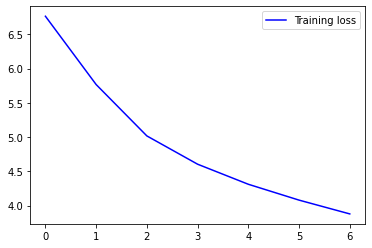

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

epoch_range = range(epoch+1)

plt.plot(epoch_range, epoch_training_loss, 'b', label='Training loss')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

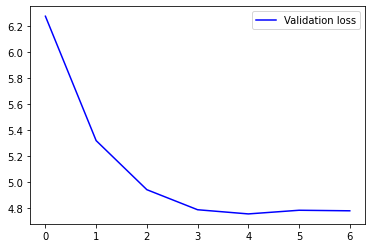

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epoch_range, epoch_validation_loss, 'b', label='Validation loss')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

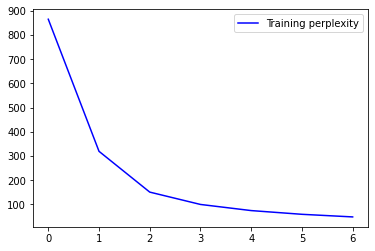

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epoch_range, epoch_training_perplexity, 'b', label='Training perplexity')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

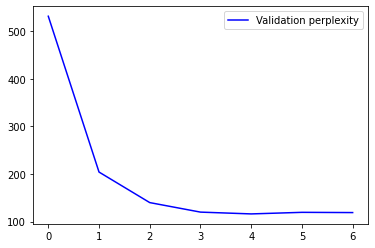

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epoch_range, epoch_validation_perplexity, 'b', label='Validation perplexity')
plt.legend()
plt.figure()